In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with dilated convolutions
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU()
        )

        # Decoder with skip connections
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU()
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU()
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU()
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1

C:\Users\Adas\AppData\Local\Temp\ipykernel_6336\362779791.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)
C:\Users\Adas\AppData\Loca

Found checkpoint. Last completed epoch: 710
Resuming training from epoch 710...
Epoch [711/1250], Training Loss: 0.0004
Epoch [711/1250], Test Loss: 0.0019
Epoch [712/1250], Training Loss: 0.0004
Epoch [712/1250], Test Loss: 0.0015
Epoch [713/1250], Training Loss: 0.0004
Epoch [713/1250], Test Loss: 0.0016
Epoch [714/1250], Training Loss: 0.0004
Epoch [714/1250], Test Loss: 0.0013
Epoch [715/1250], Training Loss: 0.0004
Epoch [715/1250], Test Loss: 0.0015
Epoch [716/1250], Training Loss: 0.0004
Epoch [716/1250], Test Loss: 0.0013
Epoch [717/1250], Training Loss: 0.0004
Epoch [717/1250], Test Loss: 0.0016
Epoch [718/1250], Training Loss: 0.0004
Epoch [718/1250], Test Loss: 0.0012
Epoch [719/1250], Training Loss: 0.0004
Epoch [719/1250], Test Loss: 0.0015
Epoch [720/1250], Training Loss: 0.0004
Epoch [720/1250], Test Loss: 0.0013
Model saved at epoch 720.
Epoch [721/1250], Training Loss: 0.0004
Epoch [721/1250], Test Loss: 0.0013
Epoch [722/1250], Training Loss: 0.0004
Epoch [722/1250], 

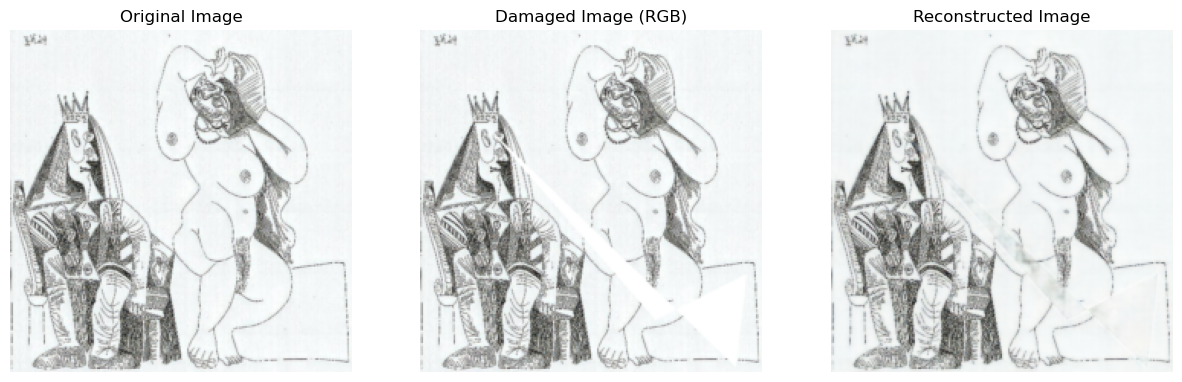

In [35]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import cv2
import numpy as np

# RandomMask class to damage images
class RandomMask:
    def __init__(self, max_size_fraction=1/16, max_vertices=8, mask_choice=None):
        self.mask_max_size = max_size_fraction
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice

    def calculate_polygon_area(self, vertices):
        """
        Calculate the area of a polygon using the shoelace formula.
        """
        n = len(vertices)
        area = 0
        for i in range(n):
            x1, y1 = vertices[i]
            x2, y2 = vertices[(i + 1) % n]  # Wrap to the first vertex
            area += x1 * y2 - y1 * x2
        return abs(area) / 2

    def validate_polygon_area(self, img, polygon_area):
        img_width, img_height = img.size
        image_resolution = img_width * img_height
        
        if polygon_area / image_resolution <= self.mask_max_size:
            return True
        else:
            return False

    def __call__(self, image):
        # Randomly decide between square mask and random mask
        if self.mask_choice is None:
            self.mask_choice = random.choice(["square", "random_square", "random_polygon", "random_noise"])
        
        # Mask size, dimensions 
        im_width, im_height = image.size
        max_mask_size = int((im_width * im_height) * self.mask_max_size)
        square_mask_size = int(max_mask_size ** 0.5)

        # Create a binary damage mask to track the damaged regions
        damage_mask = np.zeros((im_height, im_width), dtype=np.uint8)

        if self.mask_choice == "square":
            # Random mask coordinates
            x = random.randint(0, im_width - square_mask_size)
            y = random.randint(0, im_height - square_mask_size)

            # Create and apply the square mask
            region = image.crop((x, y, x + square_mask_size, y + square_mask_size))
            image.paste((255, 255, 255), (x, y, x + square_mask_size, y + square_mask_size))
            damage_mask[y:y + square_mask_size, x:x + square_mask_size] = 1

        elif self.mask_choice == "random_square":
            small_mask_size = 100
            iterations = max_mask_size // (small_mask_size * small_mask_size) 

            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)

                # Apply the random mask directly to the image
                image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
                damage_mask[y:y + small_mask_size, x:x + small_mask_size] = 1

        elif self.mask_choice == "random_polygon":
            valid_polygon_area = False
            while not valid_polygon_area:
                temp_img = image.copy()
                draw = ImageDraw.Draw(temp_img)

                # Number of vertices
                num_vertices = random.randint(3, self.max_vertices)  
                vertices = []

                for _ in range(num_vertices):
                    x = random.randint(0, im_width - 10)  
                    y = random.randint(0, im_height - 10) 
                    vertices.append((x, y))

                polygon_area = self.calculate_polygon_area(vertices)
                valid_polygon_area = self.validate_polygon_area(image, polygon_area)
            
            draw = ImageDraw.Draw(image)
            draw.polygon(vertices, fill=(255, 255, 255))
            # Create the mask for the polygon
            mask_image = Image.new("L", (im_width, im_height), 0)
            mask_draw = ImageDraw.Draw(mask_image)
            mask_draw.polygon(vertices, fill=1)
            damage_mask = np.array(mask_image) | damage_mask

        elif self.mask_choice == "random_noise":
            # Create random noise
            rng = np.random.default_rng()  # Initialize random number generator
            noise = rng.integers(0, 255, (image.height, image.width), np.uint8, True)  # Generate noise

            # Blur the noise image to control the size
            blur = cv2.GaussianBlur(noise, (0, 0), sigmaX=15, sigmaY=15, borderType=cv2.BORDER_DEFAULT)

            # Stretch the blurred image to full dynamic range
            stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0, 255)).astype(np.uint8)

            # Threshold stretched image to control the size
            thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]

            # Apply morphology open and close to smooth out shapes
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
            result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
            result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)
            total_area = 0
            max_threshold = int((im_width * im_height) * self.mask_max_size)  # Set your desired maximum area threshold here
            valid_blobs = []  # To store valid blobs

            blob_indices = list(range(1, num_labels))
            # Shuffle the blob indices randomly
            random.shuffle(blob_indices)

            for i in blob_indices:  # Start from 1 to skip the background
                area = stats[i, cv2.CC_STAT_AREA]
                if total_area + area <= max_threshold:
                    total_area += area
                    valid_blobs.append(i)  # Keep track of valid blobs

            # Create a mask from valid blobs
            valid_mask = np.zeros_like(result)
            for blob in valid_blobs:
                valid_mask[labels == blob] = 255  # Assign white to valid blobs

            # Update the damage mask
            damage_mask[valid_mask > 0] = 1

            # Create a PIL Image from the valid mask
            final_mask = Image.fromarray(valid_mask).convert("L")

            # Apply the mask to the original image (white for masked regions)
            white_mask = Image.new("RGB", image.size, (255, 255, 255))  # White mask
            image = Image.composite(white_mask, image, final_mask)

        # Add the binary damage mask as the fourth channel
        rgb_array = np.array(image)
        rgba_array = np.dstack((rgb_array, damage_mask * 255))
        return Image.fromarray(rgba_array, mode="RGBA")

class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, mask_transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
    
        # Apply transformations to the original image
        original_image = self.transform(image) if self.transform else image
    
        damaged_image = None
        if self.mask_transform:
            # Apply masking to the image to create a damaged version with an RGBA mask
            damaged_image = self.mask_transform(image.copy())
            
            # Separate the RGBA channels
            damaged_image = np.array(damaged_image)
            rgba_image = Image.fromarray(damaged_image[:, :, :3])  # RGB image
            damage_mask = Image.fromarray(damaged_image[:, :, 3])  # Alpha channel
            #print(f"RGBA Image Shape: {rgba_image.shape}, Damage Mask Shape: {damage_mask.shape}")

            # Apply the same transformations to both the RGB image and the damage mask
            if self.transform:
                rgba_image = self.transform(rgba_image)
                damage_mask = self.transform(damage_mask)
            else:
                rgba_image = transforms.ToTensor()(rgba_image)
                damage_mask = transforms.ToTensor()(damage_mask)
            
            # Concatenate the damage mask as an additional channel
            damaged_image = torch.cat((rgba_image, damage_mask), dim=0)
    
        return original_image, damaged_image



# Train function with save and resume functionality
def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        # Training loop
        for original_images, damaged_images in train_loader:
            
            #print(f"Input to Autoencoder Shape: {damaged_images.shape}")  # Should be [batch_size, 4, 224, 224]
            #print(f"First Conv Layer Expected Channels: {autoencoder.encoder[0].in_channels}")  # Should be 4
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)
        
            # Separate RGB and mask channels
            damaged_rgb = damaged_images[:, :3, :, :]  # First 3 channels
            damage_mask = damaged_images[:, 3:, :, :]  # Fourth channel
        
            # Zero the gradient buffers
            optimizer.zero_grad()
        
            # Forward pass
            _, reconstructed_images = autoencoder(damaged_images)
            
        
            # Compute the loss
            loss = criterion(reconstructed_images, original_images)
        
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
            # Accumulate loss for the epoch
            epoch_loss += loss.item()


        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.4f}")

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                _, reconstructed_images = autoencoder(damaged_images)
                #reconstructed_images = autoencoder(damaged_images)
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.4f}")

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")

# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged_rgb = damaged[:, :3, :, :].squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged_rgb)
    axes[1].set_title('Damaged Image (RGB)')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()

# Main function
if __name__ == "__main__":
    # Path to your CSV file and image directory
    csv_file = "validated_csv_easy_2.csv"
    root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
    save_path = "InpaintingAutoencoder_new_mask.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    mask_transform = RandomMask(max_size_fraction=1/16, max_vertices=8, mask_choice="random_polygon")

    # Create the dataset
    dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform, mask_transform=mask_transform)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)  # You can use any fixed integer seed
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    #train_loader = DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True)
   #test_loader = DataLoader(test_dataset, batch_size=16, num_workers=4, shuffle=False)



    # Initialize the autoencoder
    autoencoder = InpaintingAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Start or resume training
    start_epoch = 0
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    # Train the autoencoder
    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=1250, start_epoch=start_epoch)

    # Visualize some images
    original_image, damaged_image = next(iter(test_loader))  # Get one batch
    original_image = original_image[0:1]  # Select the first image
    damaged_image = damaged_image[0:1]  # Select the first damaged image
    _, reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    #reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

    # Visualize the result
    visualize_images(original_image, damaged_image, reconstructed_image)


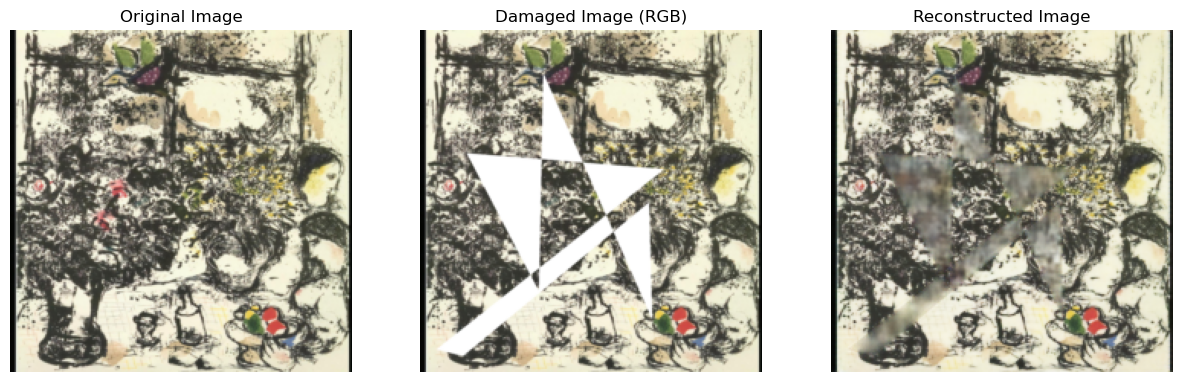

In [47]:
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
    # Visualize some images
    original_image, damaged_image = next(iter(test_loader))  # Get one batch
    original_image = original_image[0:1]  # Select the first image
    damaged_image = damaged_image[0:1]  # Select the first damaged image
    _, reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    #reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

    # Visualize the result
    visualize_images(original_image, damaged_image, reconstructed_image)


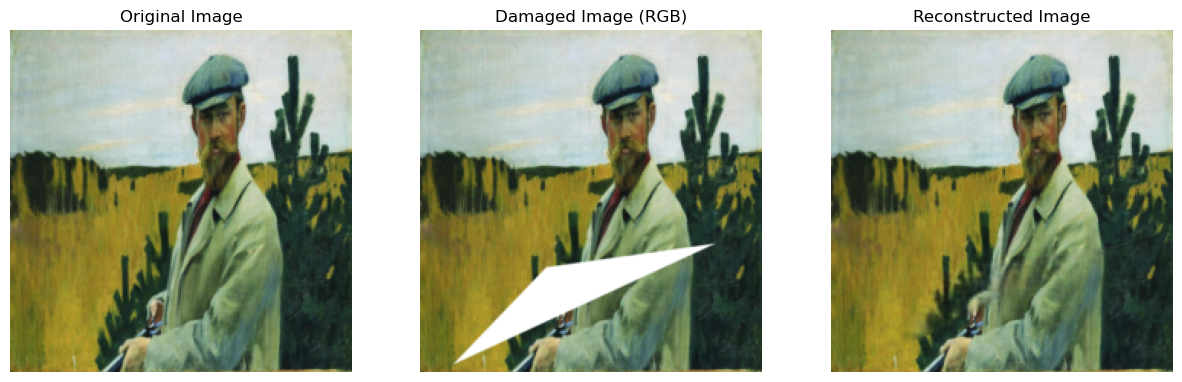

In [48]:
    # Visualize some images
    original_image, damaged_image = next(iter(train_loader))  # Get one batch
    original_image = original_image[0:1]  # Select the first image
    damaged_image = damaged_image[0:1]  # Select the first damaged image
    _, reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    #reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

    # Visualize the result
    visualize_images(original_image, damaged_image, reconstructed_image)

In [ ]:
# mozna sprobowac:

# dodany layer, aby latent space byl 2x mniejszy (ponad)

import torch
import torch.nn as nn

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # 1024x7x7
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=4, stride=2, padding=1)  # 1024x3x3
        )

        # Bottleneck with dilated convolutions
        self.bottleneck = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU()
        )

        # Decoder with skip connections
        self.decoder = nn.ModuleDict({
            "deconv5": nn.Sequential(
                nn.ConvTranspose2d(1024 + 1024, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
                nn.ReLU()
            ),
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(512 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x14x14
                nn.ReLU()
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x28x28
                nn.ReLU()
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x56x56
                nn.ReLU()
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        enc5 = self.encoder[8:10](enc4)  # 1024x7x7
        bottleneck = self.bottleneck(enc5)  # 1024x3x3

        # Decode with skip connections
        dec5 = self.decoder["deconv5"](torch.cat([bottleneck, enc5], dim=1))  # 512x7x7
        dec4 = self.decoder["deconv4"](torch.cat([dec5, enc4], dim=1))  # 256x14x14
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x28x28
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x56x56
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1

